In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os


In [4]:
mps_device = torch.device("mps")


In [5]:
torch.tensor(np.array(pd.read_csv('/Users/neisner/Documents/code/PhoebeBuffay/data/training/theta.txt', delimiter=',')))


tensor([[ 0.0000e+00,  1.6438e+01,  1.7235e-01,  ...,  8.4722e-01,
          3.7038e-01,  0.0000e+00],
        [ 1.0000e+00,  1.5357e+01, -1.3720e-02,  ...,  4.4933e-01,
          9.7484e-01,  0.0000e+00],
        [ 2.0000e+00,  2.3816e+01,  3.3310e-02,  ...,  6.9567e-01,
          5.5630e-02,  0.0000e+00],
        ...,
        [ 7.9970e+03,  2.5299e-01, -5.2870e-02,  ...,  1.0171e-01,
          3.5698e-01,  6.4487e-01],
        [ 7.9980e+03,  1.7949e+01,  4.4880e-02,  ...,  7.5792e-01,
          3.3626e-01,  2.4872e-01],
        [ 7.9990e+03,  3.6270e+00, -1.4630e-01,  ...,  7.9199e-01,
          7.8141e-01,  1.2063e-01]], dtype=torch.float64)

In [6]:
if torch.backends.mps.is_available():
   mps_device = torch.device("mps")
   x = torch.ones(1, device=mps_device)
   print (x)
else:
   print ("MPS device not found.")

tensor([1.], device='mps:0')


In [7]:
torch.mps.synchronize()

In [8]:
# # get the data ready

# batch_size = 64
# val_cut = 997
# df = pd.read_csv('/Users/neisner/Documents/code/PhoebeBuffay/data/training/theta.txt', delimiter=',')
# mtx = np.array(df)
# T = torch.tensor(mtx, dtype=torch.float64)
# training_data = torch.utils.data.TensorDataset(T)

# print(np.shape(training_data))

# # training_data = torch.utils.data.TensorDataset(torch.tensor(np.zeros((100,19))), torch.tensor(np.zeros((100,500))))
# training_generator = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

# # validation_data = torch.utils.data.TensorDataset(torch.tensor(np.zeros((20,19))), torch.tensor(np.zeros((20,500))))
# # validation_data = torch.utils.data.TensorDataset(torch.tensor(np.load('/Users/neisner/Documents/code/PhoebeBuffay/data/training/theta.txt'), dtype=torch.float32, allow_pickle=True), torch.tensor(np.load('/Users/neisner/Documents/code/PhoebeBuffay/data/training/simulations.npy'), dtype=torch.float32, allow_pickle=True))

# validation_generator = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)


In [18]:
# get the data ready

batch_size = 64
val_cut = 997
cut = 6000

data = torch.tensor(np.array(pd.read_csv('/Users/neisner/Documents/code/PhoebeBuffay/data/training/theta.txt', delimiter=',', usecols = range(1,17))))
label = torch.tensor(np.array(pd.read_csv('/Users/neisner/Documents/code/PhoebeBuffay/data/training/simulations.txt', delimiter=',', usecols = range(1,501))))

training_data = torch.utils.data.TensorDataset(data[0:cut], label[0:cut])

# training_data = torch.utils.data.TensorDataset(torch.tensor(np.zeros((100,19))), torch.tensor(np.zeros((100,500))))

training_generator = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

validation_data = torch.utils.data.TensorDataset(data[cut:-1], label[cut:-1])

# validation_data = torch.utils.data.TensorDataset(torch.tensor(np.load('/Users/neisner/Documents/code/PhoebeBuffay/data/training/theta.txt'), dtype=torch.float32, allow_pickle=True), torch.tensor(np.load('/Users/neisner/Documents/code/PhoebeBuffay/data/training/simulations.npy'), dtype=torch.float32, allow_pickle=True))

validation_generator = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)


In [10]:
len(label[0])

500

In [19]:

class buffayCNN(nn.Module):
    def __init__(self):
        super(buffayCNN, self).__init__()
        self.linear1 = nn.Linear(16, 500)
        self.linear2 = nn.Linear(500, 780)
        self.linear3 = nn.Linear(780, 4000)
        
        self.conv1 = nn.Conv1d(1, 20, kernel_size=3, stride=1, padding=1)
        #self.maxpool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(20,100, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(100, 150, kernel_size=3, stride=1, padding=1)
        #self.maxpool3 = nn.MaxPool1d(2)
        self.conv4 = nn.Conv1d(150, 100, kernel_size=3, stride=1, padding=1)
        self.maxpool4 = nn.MaxPool1d(2)
        
        self.conv5 = nn.Conv1d(100, 20, kernel_size=3, stride=1, padding=1)
        #self.maxpool5 = nn.MaxPool1d(2)
        self.conv6 = nn.Conv1d(20, 1, kernel_size=3, stride=1, padding=1)
        self.maxpool6 = nn.MaxPool1d(2)

        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))

        x = self.relu((self.conv1(x.reshape((x.shape[0], 1, x.shape[1])))))
        # x = self.maxpool1(x)
        
        x = self.relu((self.conv2(x)))
        x = self.maxpool2(x)
        
        x = self.relu((self.conv3(x)))
        # x = self.maxpool3(x)
        
        x = self.relu((self.conv4(x)))
        x = self.maxpool4(x)
        
        x = self.relu((self.conv5(x)))
        # x = self.maxpool5(x)
        
        x = self.relu((self.conv6(x)))
        x = self.maxpool6(x)
        
                
        return x.squeeze()

# Create an instance of the SimpleCNN model
model = buffayCNN()
model.to(mps_device)

# model.cuda() # move to the GPU 

# Print the model architecture
print(model)


buffayCNN(
  (linear1): Linear(in_features=16, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=780, bias=True)
  (linear3): Linear(in_features=780, out_features=4000, bias=True)
  (conv1): Conv1d(1, 20, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(20, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(100, 150, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(150, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(100, 20, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv6): Conv1d(20, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


In [22]:
# model(torch.zeros((10,16))).shape

In [23]:
# build a dierectroy to save the model

training_index = 1

os.makedirs(f'./model_{training_index}', exist_ok=True)
checkpoint_path = f'./model_{training_index}/checkpoint.pth'
# checkpoint_dir = os.path.dirname(checkpoint_path)


In [26]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 1

val_losses = []
train_losses = []

best_val_loss = np.inf

for epoch in range(epochs):
    
    temp_train_losses = []
    
    for i, (x, y) in enumerate(training_generator):
        
        
        x = x.to(torch.float32)
        y = y.to(torch.float32)

        x, y = x = x.to(mps_device), y.to(mps_device)
        
        # x,y = x.cuda(), y.cuda() # move it to the GPU
        
        # Clear the gradients
        optimizer.zero_grad()
        
        model.train()
        
        # Forward pass
        y_hat = model(x)
        
        # Compute the loss
        loss = loss_fn(y_hat, y)
        temp_train_losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()
    
    train_losses.append(np.mean(np.array(temp_train_losses)))
    
    temp_val_losses = []
    
    for i, (x, y) in enumerate(validation_generator):
        x = x.to(torch.float32)
        y = y.to(torch.float32)
        
        x, y = x = x.to(mps_device), y.to(mps_device)
        
        # x,y = x.cuda(), y.cuda()
        
        model.eval() 
        
        # Forward pass
        y_hat_val = model(x)
        
        # Compute the loss
        val_loss = loss_fn(y_hat_val, y)
        
        temp_val_losses.append(val_loss.item())
            
    val_losses.append(np.mean(np.array(temp_val_losses)))
    
    if np.mean(np.array(temp_val_losses)) < best_val_loss:
        best_val_loss = np.mean(np.array(temp_val_losses))
        torch.save(model.state_dict(), checkpoint_path)
    
    # Print the loss every 100 iterations
    if i % 100 == 0:
        print(f'Epoch {_}, Iteration {i}, loss: {loss.item()}')

model.train()

TypeError: linear(): argument 'input' (position 1) must be Tensor, not tuple

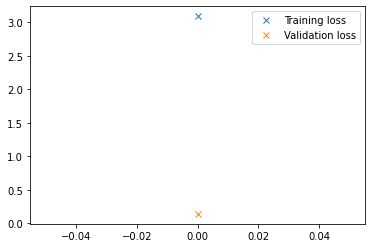

In [19]:
plt.figure()
plt.plot(np.linspace(0,3,len(train_losses)),train_losses,"x", label='Training loss')
plt.plot(np.linspace(0,3,len(train_losses)), val_losses, "x",label='Validation loss')
plt.legend()